In [2]:
import matplotlib.pyplot as plt
import random
import glob
import cv2
import numpy as np
import os
from keras_facenet import FaceNet

# 耶鲁数据集B 数据分析

不同光照下的人脸图像。测试的场景是不同光照角度下的人脸识别是否准确。 现在已经有数据集，结构如下：一个CroppedYalePNG文件夹，下面有共39个人的不同光照角度的人脸图片，每个人有多张，共2452个图片，注意：图片都在同一个文件夹中。命名规范如下：yaleB01_P00A+005E+10.png 01代表第一个人， A+005代表是灯光方位角为+005，E+10代表灯光仰角为+10. 先以每个人的正对镜头图片作为模型的输入（就是方位角小等于20度且俯仰角小于等于20度即可），得到并保存对应的特征向量（应该一共39个）然后将剩下的图片作为输入，看看得到的特征向量与先前保存的39个中哪个最接近，且最接近编号的是否对应该图片中人脸的编号，以此来计算准确率并输出结果。

<>:2: SyntaxWarning: invalid escape sequence '\C'
<>:2: SyntaxWarning: invalid escape sequence '\C'
C:\Users\18084\AppData\Local\Temp\ipykernel_18316\653339278.py:2: SyntaxWarning: invalid escape sequence '\C'
  files = glob.glob('.\CroppedYalePNG/*.png') # 输入文件路径 返回匹配的文件列表


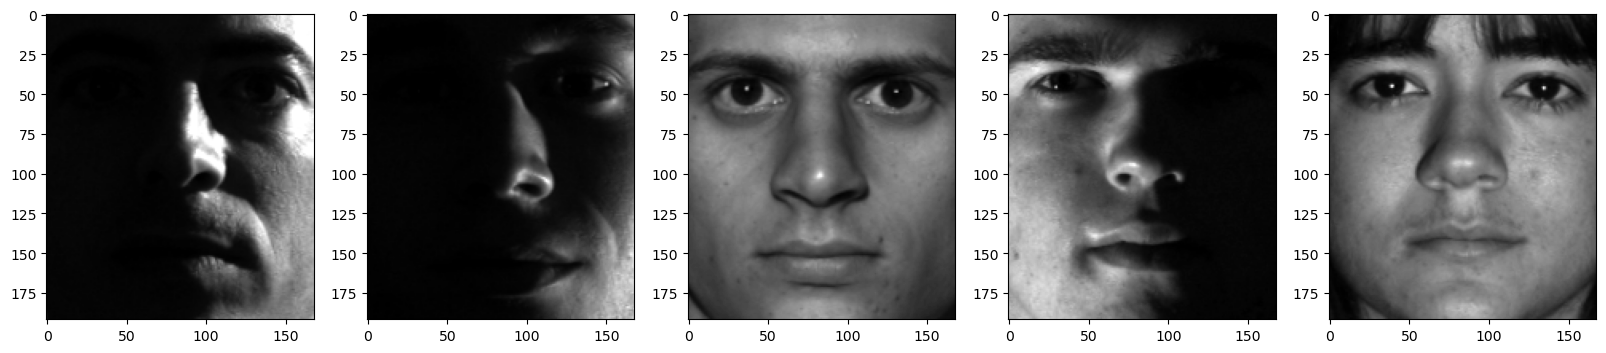

In [3]:

random.seed(0)
files = glob.glob('.\CroppedYalePNG/*.png') # 输入文件路径 返回匹配的文件列表
files = [file_ for file_ in files if 'Ambient' not in os.path.basename(file_)]  # 去掉Ambient文件
files = sorted(files) # 按照文件名排序 
random.shuffle(files) # 随机打乱文件

random.seed() # 实际上没有传入具体的种子值，因此会使用系统时间作为种子。
k = 5

fig, axs = plt.subplots(1, k, figsize=(20, int(20 / k))) #  Matplotlib 创建一个 1 行 k 列的子图布局。figsize设定了图像的大小，这里是宽度为 20，高度由 int(20 / k) 决定，即根据 k 自动调整
for ax, file_ in zip(axs, random.choices(files, k=k)): # 从 files 列表中随机选择 k 个文件,然后使用 zip() 将每个子图 (ax) 和选择的文件 (file_) 进行配对
    ax.imshow(cv2.imread(file_, cv2.IMREAD_UNCHANGED), cmap='gray')
    # 对于每个选择的文件，读取图像，并在对应的子图中显示。cv2.imread() 使用 cv2.IMREAD_UNCHANGED 读取图像，不改变其颜色通道。
    # cmap='gray' 表示将图像以灰度模式显示。
plt.show()

random.seed(0)

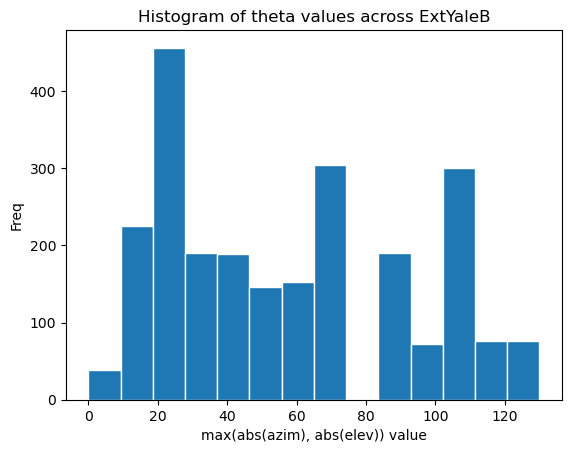

In [4]:
# 数据通过光源对于人脸的方位角和仰角实现的
# 最终关心的是这两者绝对值的最大值。

def get_max_azim_elev(file_):
    base = os.path.basename(file_) # 获取文件名（包含扩展名）。 角度在文件名中
    base = os.path.splitext(base)[0] # 去掉文件扩展名，保留文件名基本部分。
    
    azim, elev = base.split('_')[-1].split('A')[-1].split('E') # 进一步分割该部分来提取方位角（azim）和仰角（elev）。
    azim, elev = int(azim), int(elev)
    return max(abs(azim), abs(elev)) # 返回方位角和仰角绝对值中的最大值。
 
thetas = list(map(get_max_azim_elev, files)) # 对每个文件调用 get_max_azim_elev 函数，得到每个文件对应的最大角度值。
thetas = np.array(thetas)

# 确保角度合理
assert len(thetas) == len(files)
assert min(thetas) >= 0
assert max(thetas) <= 180

# 角度值分布情况
fig = plt.figure()
plt.hist(thetas, bins='auto', histtype='bar', ec='white')
plt.xlabel('max(abs(azim), abs(elev)) value')
plt.ylabel('Freq')
plt.title("Histogram of theta values across ExtYaleB")
plt.show()

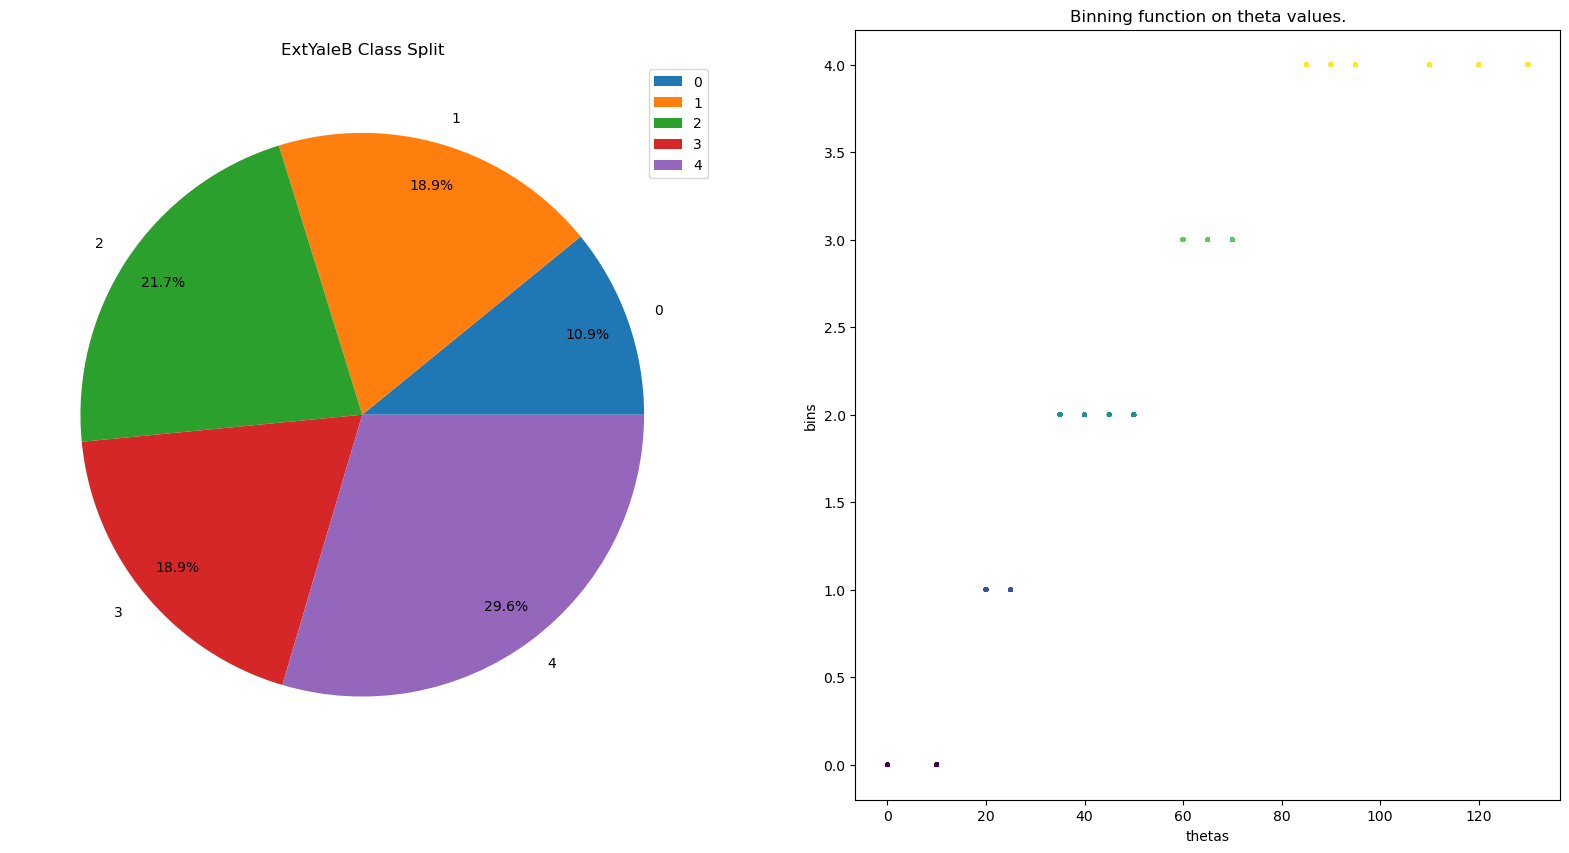

In [5]:

# 共5个类别 数字0对应最强的光照，数字4对应光照最弱。

# Extract the class labels from the thetas
def bin_theta(theta):
    if theta < 12:
        return 0
    elif 20 <= theta <= 25:
        return 1
    elif 35 <= theta <= 50:
        return 2
    elif 60 <= theta < 77:
        return 3
    elif theta > 77:
        return 4
    else:
        raise ValueError

y = np.array(list(map(bin_theta, thetas))) # 角度映射到5种类别中
assert min(y) == 0
assert max(y) == 4
assert len(y) == len(files)

unq, unq_cnts = np.unique(y, return_counts=True)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
ax1.pie(unq_cnts, rotatelabels=False, labels=unq, autopct='%1.1f%%', pctdistance=0.85)
ax1.legend()
ax1.set_title('ExtYaleB Class Split')

ax2.scatter(thetas, y, s=5, c=y)
ax2.set(xlabel='thetas', ylabel='bins')
ax2.set_title('Binning function on theta values.')
plt.show()

# 测试开始

In [6]:
embedder = FaceNet()
# 设定数据集路径
data_dir = './CroppedYalePNG'  

In [7]:
# 用于存储特征向量
feature_vectors = {}
correct_labels = []

# 读取每个人的正对镜头图片并提取特征
for i in range(1, 40):  # 39个人
    person_id = f'yaleB{i:02d}'

    for filename in os.listdir(data_dir):
        if filename.endswith('.png') and not filename.endswith('Ambient.png') and person_id in filename:
            # 解析文件名
            parts = filename.split('_')
            angles = parts[1]  # 获取A和E的值
            azimuth = int(angles[4:8])  # 方位角
            elevation = int(angles[9:12])  # 俯仰角

            # 选择正对镜头的图片（方位角小于等于20度且俯仰角小于等于20度）
            if abs(azimuth) <= 20 and abs(elevation) <= 20:
                # 加载和处理图像
                img_path = os.path.join(data_dir, filename)
                image = cv2.imread(img_path)
                
                if image is None:
                    print(f"Error: Unable to load image {img_path}.")
                    continue

                # 调整大小并获取特征
                image_resized = cv2.resize(image, (160, 160))
                image_expanded = np.expand_dims(image_resized, axis=0)  # 形状变为 (1, 160, 160, 3)
                embeddings = embedder.embeddings(image_expanded)
                
                # 保存特征向量
                feature_vectors[person_id] = embeddings[0]  # 取第一张图的特征
                correct_labels.append(person_id)  # 保存对应标签
                break  # 找到一张正对镜头后跳出，继续下一个人


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━

KeyboardInterrupt: 

In [ ]:
# 计算准确率
correct_count = 0
total_count = 0

low_degree_correct_count = 0
low_degree_total_count = 0

def get_max_azim_elev(filename):
    parts = filename.split('_')
    angles = parts[1]
    azimuth = int(angles[4:8])  # 方位角
    elevation = int(angles[9:12])  # 俯仰角
    return max(abs(azimuth), abs(elevation))


# 遍历剩下的所有图像
for i in range(1, 40):
    person_id = f'yaleB{i:02d}'
    for filename in os.listdir(data_dir) :
        if filename.endswith('.png')and not filename.endswith('Ambient.png'):
            # 跳过正对镜头的图片
            parts = filename.split('_')
            angles = parts[1]
            azimuth = int(angles[4:8])  # 方位角
            elevation = int(angles[9:12])  # 俯仰角

            if abs(azimuth) <= 20 and abs(elevation) <= 20:
                continue

            # 加载和处理图像
            img_path = os.path.join(data_dir, filename)
            image = cv2.imread(img_path)

            if image is None:
                print(f"Error: Unable to load image {img_path}.")
                continue
            
            # 获取特征
            image_resized = cv2.resize(image, (160, 160))
            image_expanded = np.expand_dims(image_resized, axis=0)
            embeddings = embedder.embeddings(image_expanded)

            # 计算与已经保存的特征的距离
            distances = {}
            for ref_id, ref_embedding in feature_vectors.items():
                distance = np.linalg.norm(embeddings[0] - ref_embedding)  # 计算L2距离
                distances[ref_id] = distance

            # 找到最近的特征
            closest_id = min(distances, key=distances.get)
            if closest_id == person_id:
                correct_count += 1
                if get_max_azim_elev(filename) <= 45:
                    low_degree_correct_count += 1
                    low_degree_total_count+=1
            total_count += 1
    print(f'Person {person_id} done.')
    

In [8]:
# 计算并输出准确率
accuracy = correct_count / total_count if total_count > 0 else 0
print(f'Accuracy: {accuracy * 100:.2f}%')

# 低亮度准确率
low_degree_accuracy = low_degree_correct_count / low_degree_total_count if low_degree_total_count > 0 else 0
print(f'Low degree accuracy: {low_degree_accuracy * 100:.2f}%')

# 高亮度准确率
high_degree_accuracy = (correct_count - low_degree_correct_count) / (total_count - low_degree_total_count) if (total_count - low_degree_total_count) > 0 else 0
print(f'High degree accuracy: {high_degree_accuracy * 100:.2f}%')

# 数据准备
labels = ['accuracy', 'low_degree_accuracy', 'high_degree_accuracy']
accuracies = [accuracy, low_degree_accuracy, high_degree_accuracy]

# 绘制柱状图
plt.figure(figsize=(12, 6))

# 创建柱状图
plt.subplot(1, 2, 1)  # 1行2列的第1个图
plt.bar(labels, [a * 100 for a in accuracies], color=['#4CAF50', '#FF6384', '#2196F3'])
plt.ylabel('accuracy (%)')
plt.title('model evaluation')
plt.ylim(0, 100)

# 创建饼图
plt.subplot(1, 2, 2)  # 1行2列的第2个图
colors = ['#4CAF50', '#FF6384', '#2196F3']
plt.pie([a * 100 for a in accuracies], labels=labels, colors=colors, autopct='%1.1f%%', startangle=90)
plt.axis('equal')  # 保持饼图的比例

plt.title('accuracy ratio')

plt.tight_layout()
plt.show()

NameError: name 'total_count' is not defined